In [5]:
pip install yfinance

     -------------------------------------- 63.2/63.2 kB 423.5 kB/s eta 0:00:00
     ------------------------------------ 112.2/112.2 kB 545.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [21]:
# Retrieve two weeks of Bitcoin to USD exchange rates with a 1 hour interval and save the dataframe to a variable.
BTC_USD = yf.download("BTC-USD", start='2020-01-01', end='2020-12-31', interval='1d')
BTC_USD.to_csv('crypto.csv')

[*********************100%***********************]  1 of 1 completed


In [8]:
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


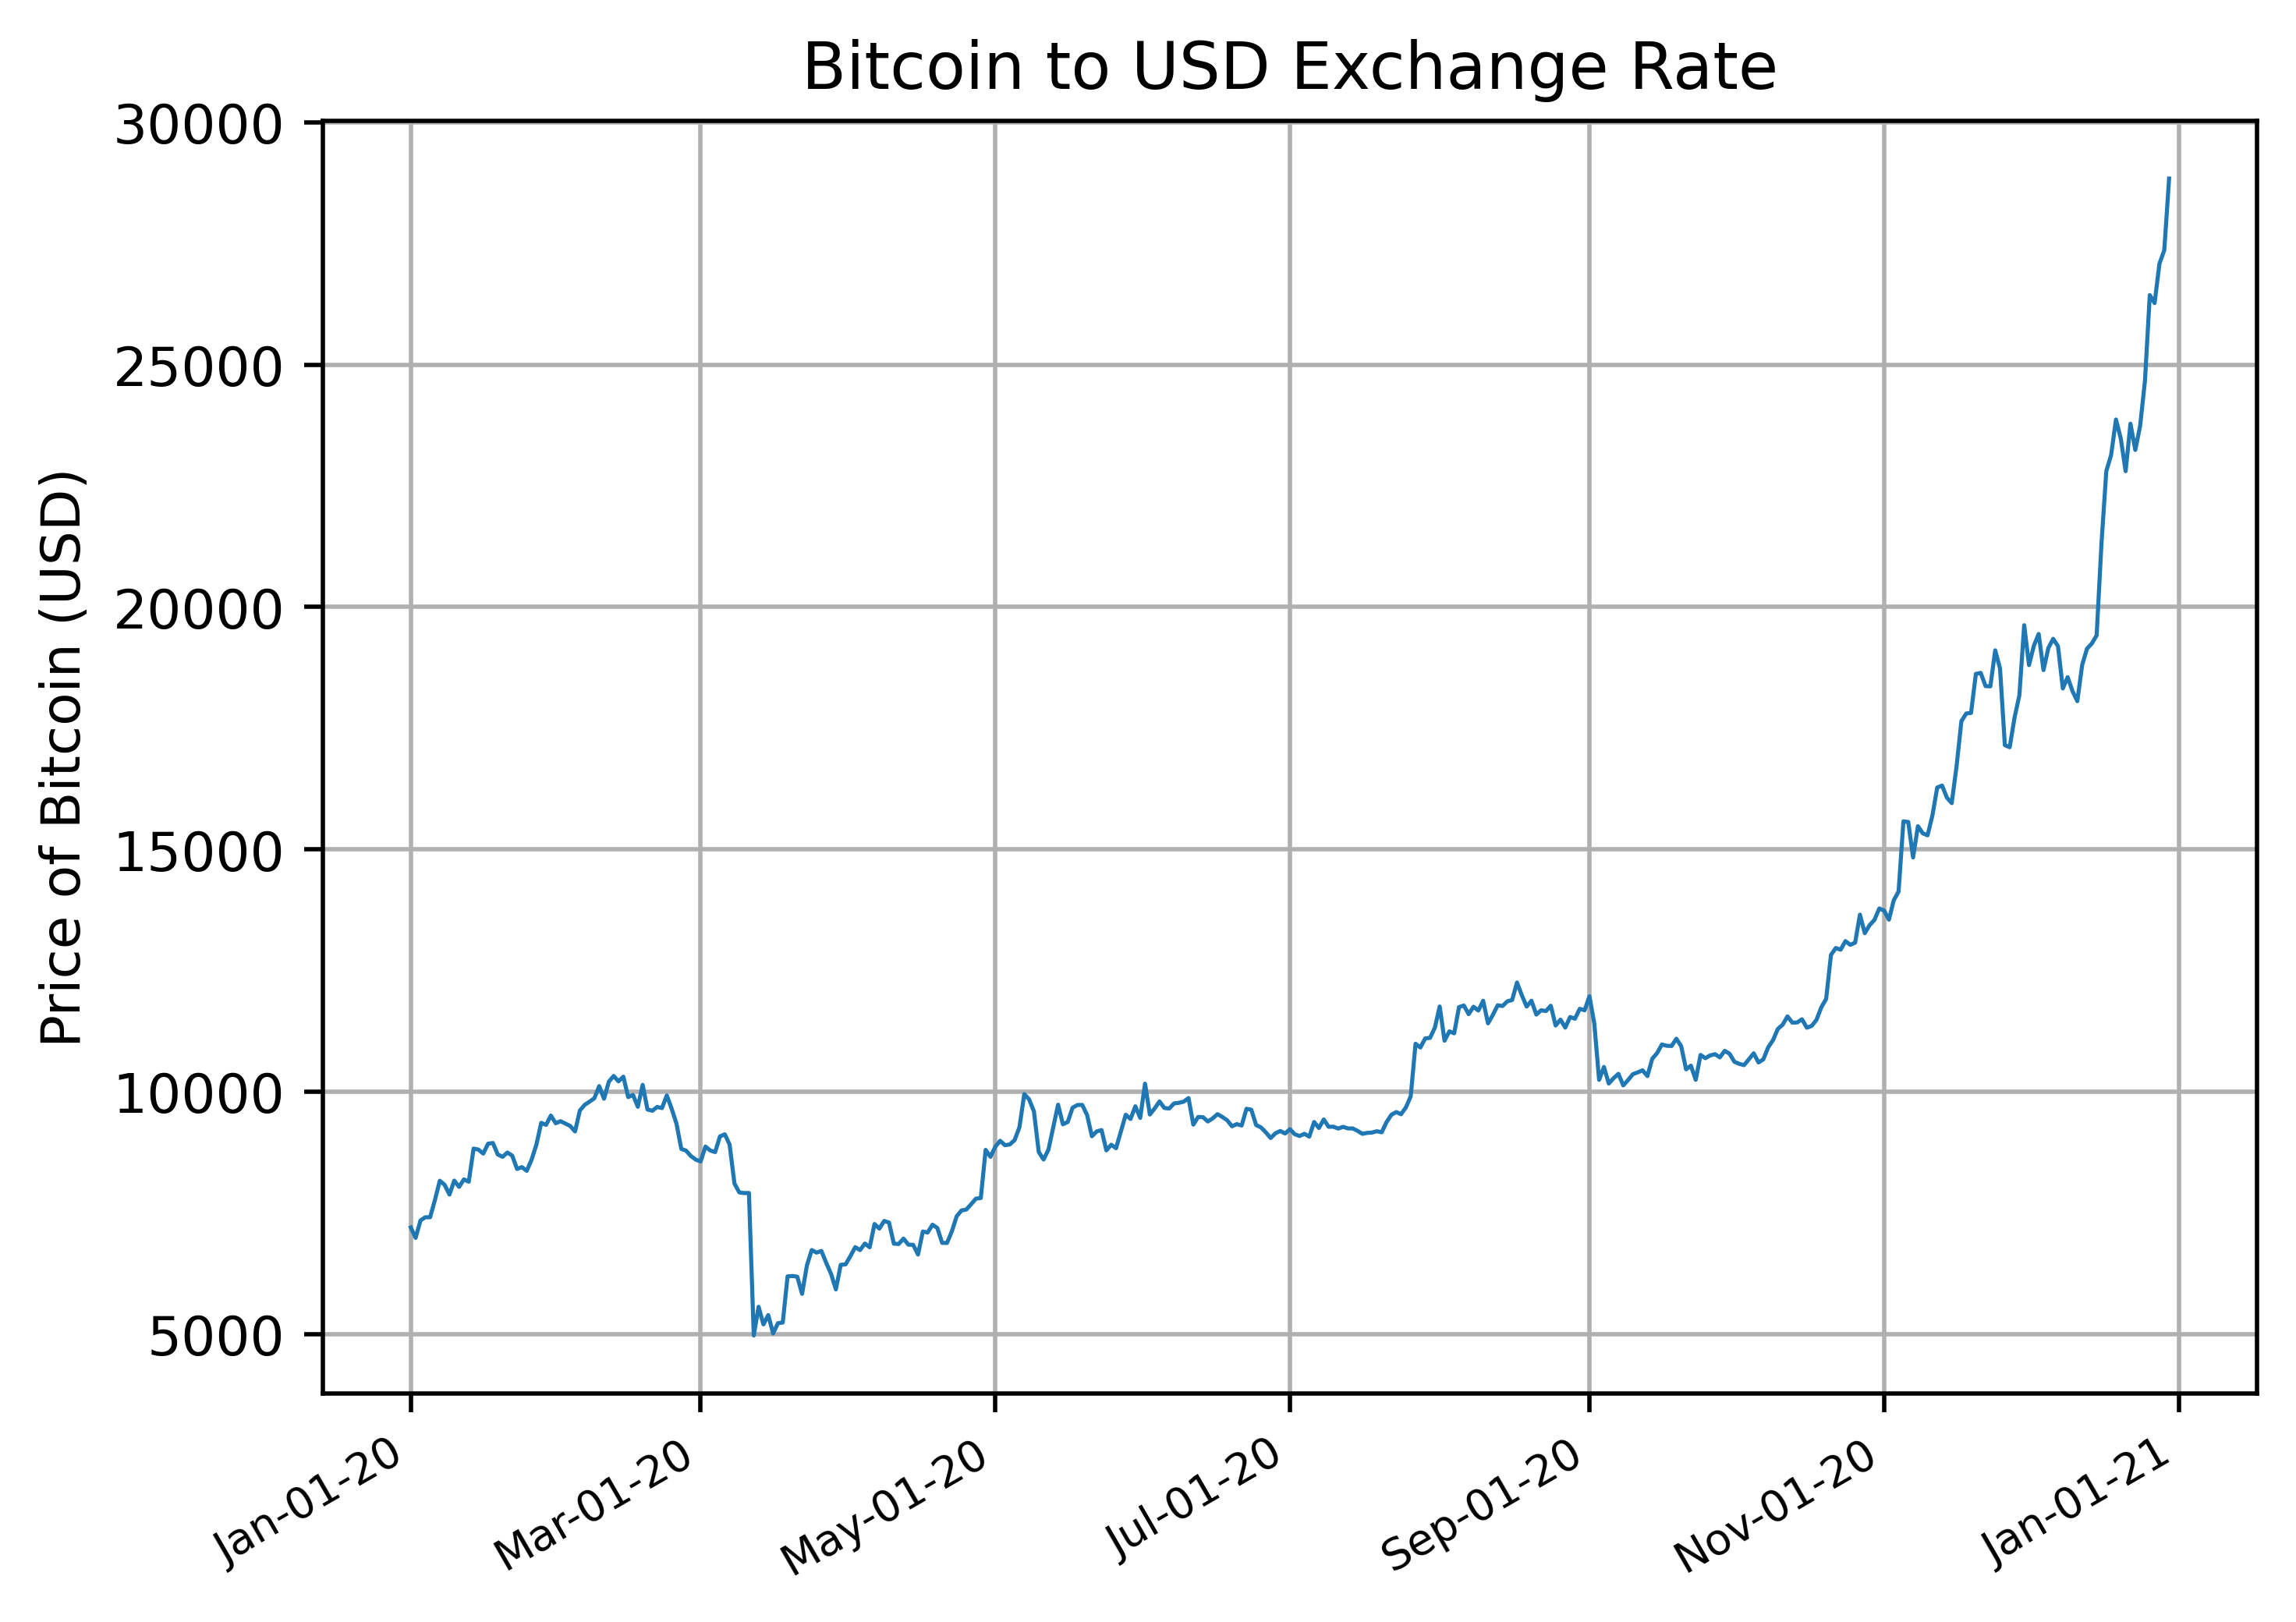

In [9]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75)

# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid

# Displaying the price chart
plt.show()

In [12]:
# Compute a 9-day Simple Moving Average with pandas
BTC_USD['SMA_9'] = BTC_USD['Close'].rolling(window=9, min_periods=1).mean()
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window=30, min_periods=1).mean()

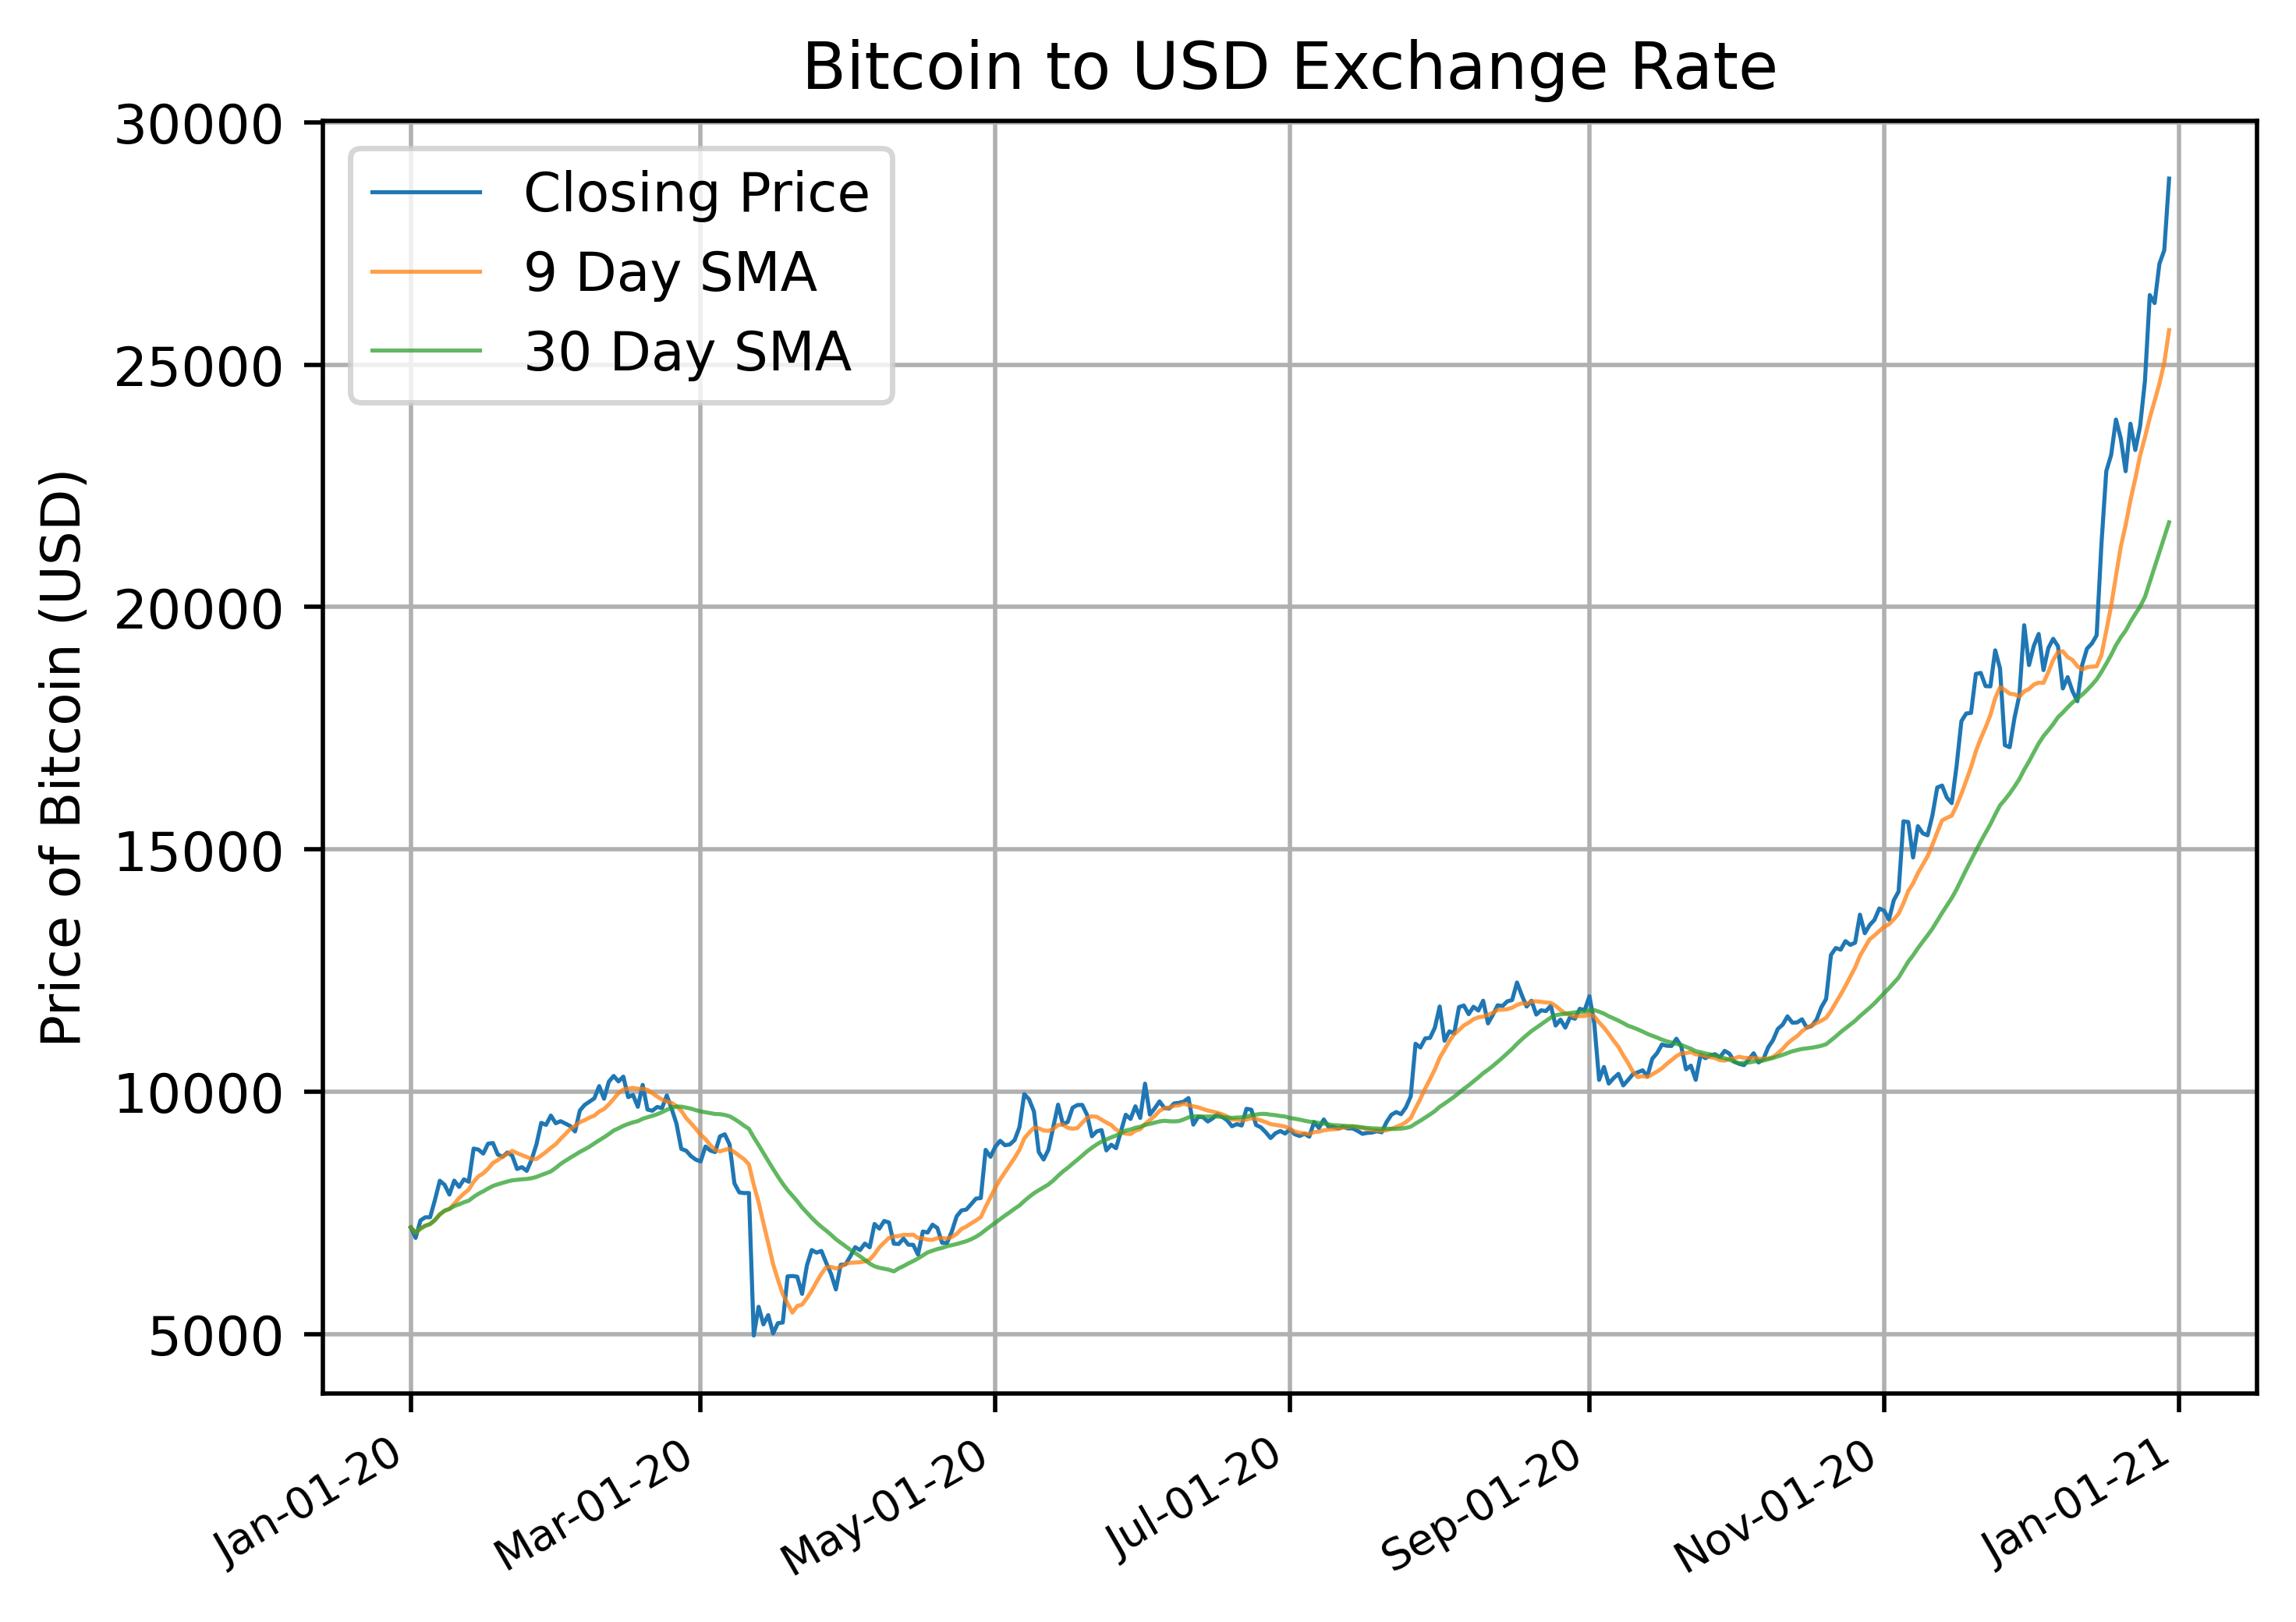

In [13]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price') # Added label

"""
You have already seen the code above earlier - we are simply reusing it.
Below we plot the 9 and 30 day Simple Moving Averages and give them the appropriate label
"""
ax.plot(BTC_USD['SMA_9'], lw=0.75, alpha=0.75, label='9 Day SMA')
ax.plot(BTC_USD['SMA_30'], lw=0.75, alpha=0.75, label='30 Day SMA')


# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()

In [14]:
# Create a pandas dataframe that is the same size as the BTC_USD dataframe and covers the same dates
trade_signals = pd.DataFrame(index=BTC_USD.index)

# Define the intervals for the Fast and Slow Simple Moving Averages (in days)
short_interval = 10
long_interval = 40

# Compute the Simple Moving Averages and add it to the dateframe as new columns
trade_signals['Short'] = BTC_USD['Close'].rolling(window=short_interval, min_periods=1).mean()
trade_signals['Long'] = BTC_USD['Close'].rolling(window=long_interval, min_periods=1).mean()

In [16]:
# Create a new column populated with zeros
trade_signals['Signal'] = 0.0

# Wherever the Shorter term SMA is above the Longer term SMA, set the Signal column to 1, otherwise 0
trade_signals['Signal'] = np.where(trade_signals['Short'] > trade_signals['Long'], 1.0, 0.0)   
trade_signals['Position'] = trade_signals['Signal'].diff()

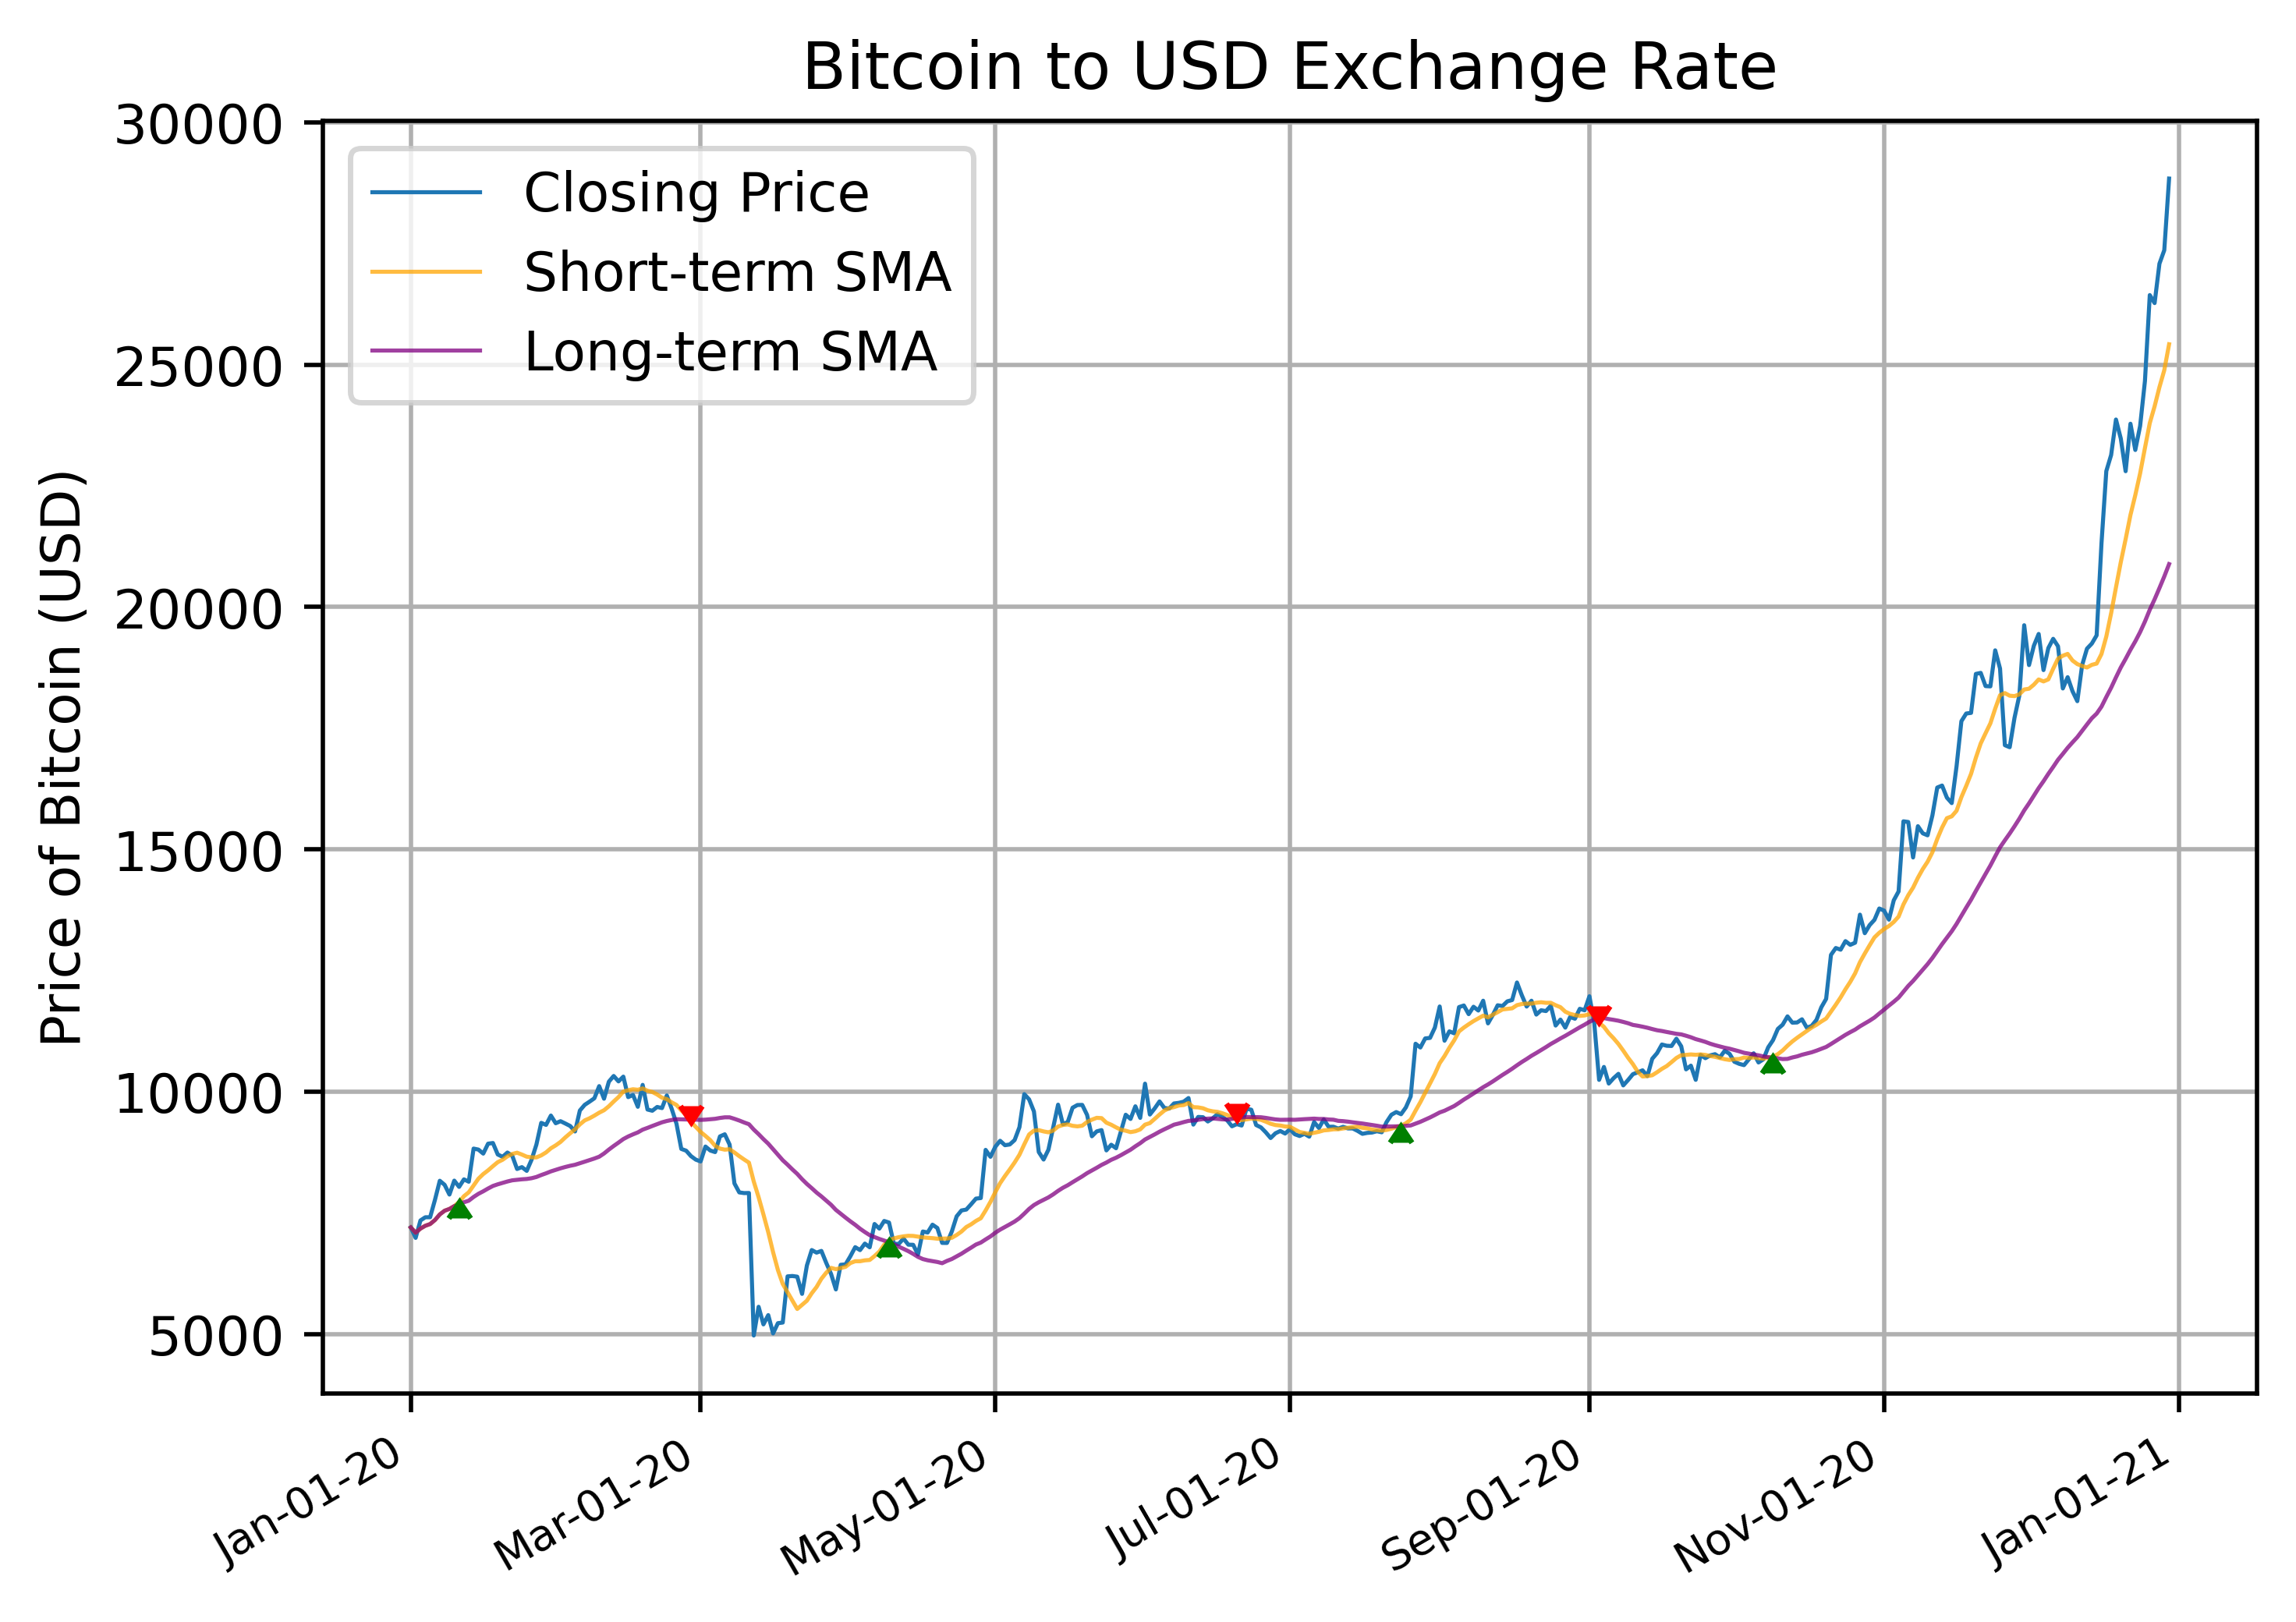

In [17]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()


# Plotting the Bitcoin closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price')

# Plot the shorter-term moving average
ax.plot(trade_signals['Short'], lw=0.75, alpha=0.75, color='orange', label='Short-term SMA')

# Plot the longer-term moving average
ax.plot(trade_signals['Long'], lw=0.75, alpha=0.75, color='purple', label='Long-term SMA')


# Adding green arrows to indicate buy orders
ax.plot(trade_signals.loc[trade_signals['Position']==1.0].index, trade_signals.Short[trade_signals['Position'] == 1.0],
 marker=6, ms=4, linestyle='none', color='green')

 # Adding red arrows to indicate sell orders
ax.plot(trade_signals.loc[trade_signals['Position'] == -1.0].index, trade_signals.Short[trade_signals['Position'] == -1.0],
 marker=7, ms=4, linestyle='none', color='red')


# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()

In [18]:
# Define how much money you will start with (in USD)
initial_balance = 10000.0 # ten thousand USD

# Create dataframe containing all the dates considered
backtest = pd.DataFrame(index=trade_signals.index)

# Add column containing the daily percent returns of Bitcoin
backtest['BTC_Return'] = BTC_USD['Close'] / BTC_USD['Close'].shift(1) # Current closing price / yesterday's closing price


In [19]:

# Add column containing the daily percent returns of the Moving Average Crossover strategy
backtest['Alg_Return'] = np.where(trade_signals.Signal == 1, backtest.BTC_Return, 1.0)

# Add column containing the daily value of the portfolio using the Crossover strategy
backtest['Balance'] = initial_balance * backtest.Alg_Return.cumprod() # cumulative product

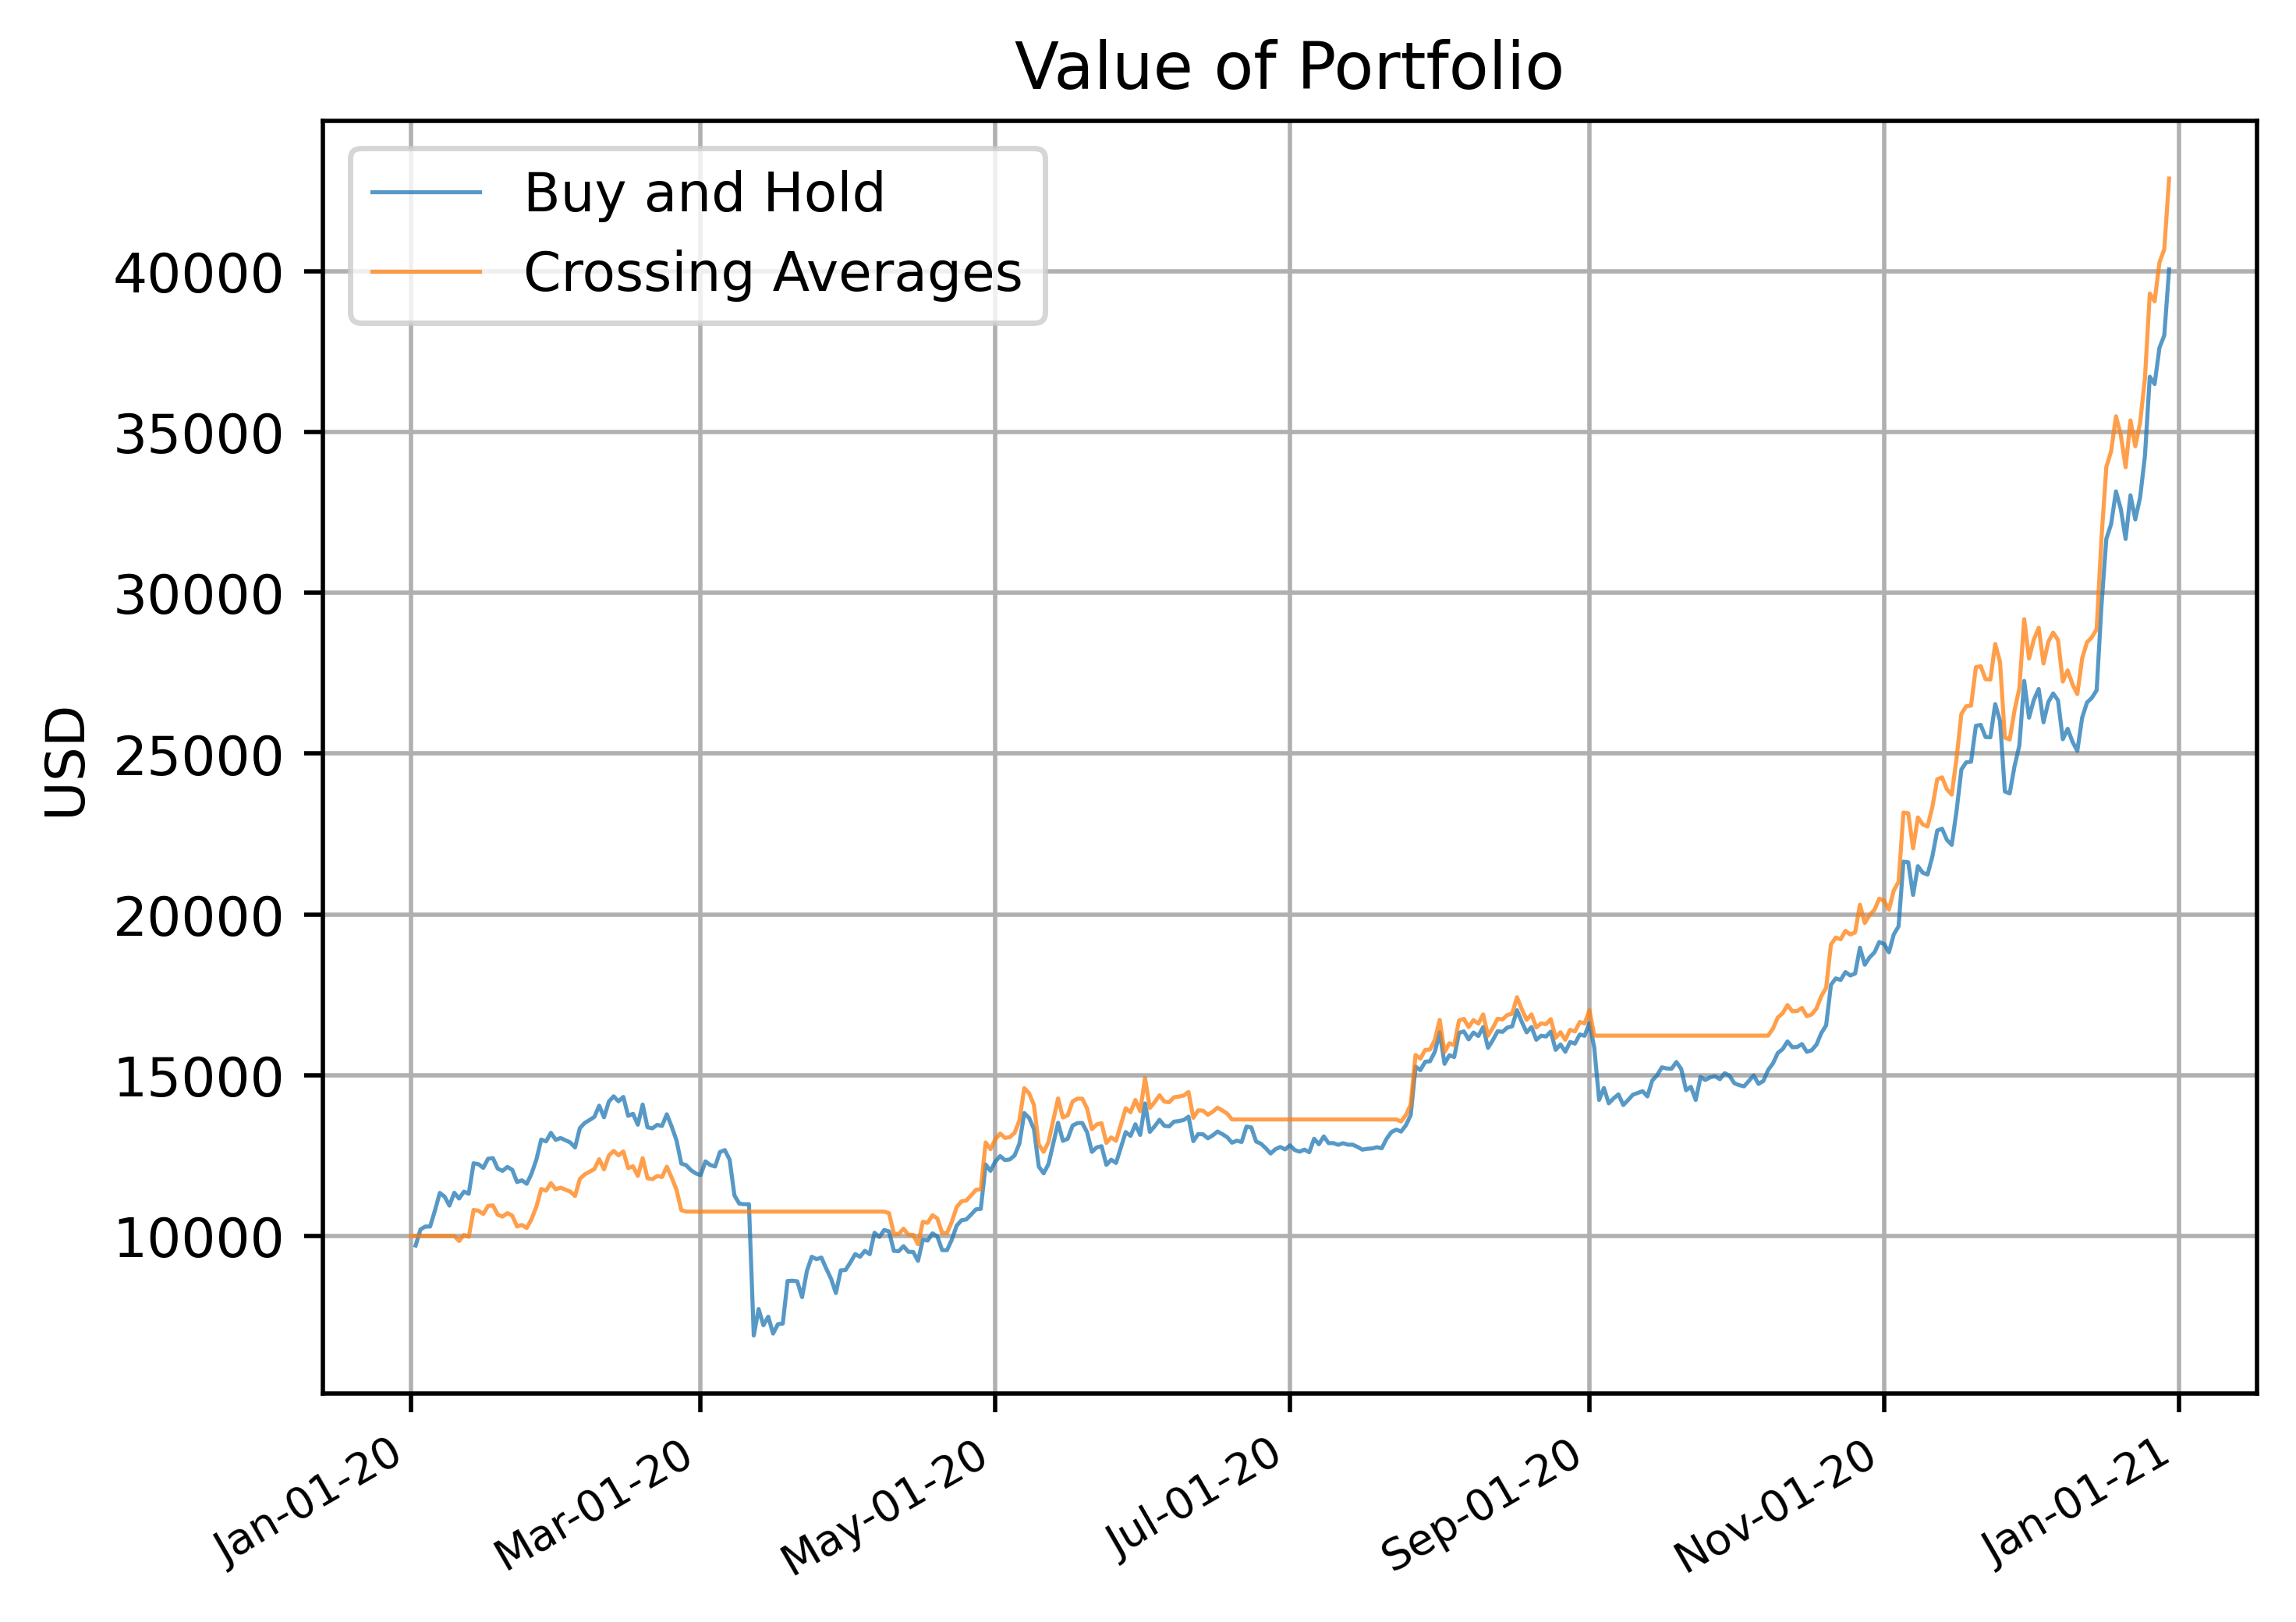

In [20]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the value of Buy and Hold Strategy
ax.plot(initial_balance*backtest.BTC_Return.cumprod(), lw=0.75, alpha=0.75, label='Buy and Hold')

# Plotting total value of Crossing Averages Strategy
ax.plot(backtest['Balance'], lw=0.75, alpha=0.75, label='Crossing Averages')

# Adding labels and title to the plot
ax.set_ylabel('USD')
ax.set_title('Value of Portfolio')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()